# Large Scale Distributed Data Science using Apache Spark 2.2

By James G. Shanahan1, 2 and Liang Dai1, 3 <P>
1 NativeX and iSchool, 2 UC Berkeley, CA, 3  UC Santa Cruz <P>

EMAIL: James_DOT_Shanahan_AT_gmail_DOT_com

# KMeans
## Data Generation

In [1]:
%matplotlib inline
import pylab 
import json
import numpy as np
import pandas as pd
import random
from IPython.display import display

In [21]:
# generate data
size1 = size2 = size3 = 1000

samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1

samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)

samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)

# Randomize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

# Data Visualiazation

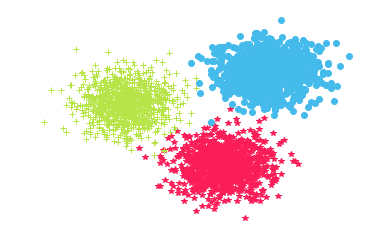

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(samples1[:, 0], samples1[:, 1],'*', color = '#fa1d57')
ax.plot(samples2[:, 0], samples2[:, 1],'o',color = '#45bbec')
ax.plot(samples3[:, 0], samples3[:, 1],'+',color = '#b7e549')
ax.axis('off')
plt.show()

# Set enviroment variable for PySpark

In [4]:
'''
https://spark.apache.org/docs/latest/quick-start.html#self-contained-applications
There is an error in the example given ^^. builder is not executable

Only build a session if not on docker container (i.e. hostname in Docker is 'quickstart')
'''
from os import environ
try:
    host = environ['HOSTNAME']
except KeyError:
    host = 'not docker'

if host=='quickstart':
    pass
else:
    from pyspark.sql import SparkSession
    app_name = "kmeans"
    master = "local[*]"
    spark = SparkSession.builder.appName(app_name).master(master).getOrCreate()

In [5]:
# run this cell to get the correct link to the Spark UI
spark

In [6]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(line[0]),float(line[1])])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    fig, ax = plt.subplots()
    colors = ['#edf6b2','#000000']
    ax.plot(samples1[:, 0], samples1[:, 1], '.', color = colors[0])
    ax.plot(samples2[:, 0], samples2[:, 1], '.', color = colors[0])
    ax.plot(samples3[:, 0], samples3[:, 1],'.', color = colors[0])
    ax.plot(means[0][0], means[0][1],'*',markersize =10,color = colors[1])
    ax.plot(means[1][0], means[1][1],'*',markersize =10,color = colors[1])
    ax.plot(means[2][0], means[2][1],'*',markersize =10,color = colors[1])
    ax.axis('off')
    plt.show()

## Distributed KMeans in Spark

In [104]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = spark.read.format("csv").load("./data.csv").rdd.cache()

### sanity checks 1:

#### map and reduce

In [106]:
print "We are working with data type:\n"+"-"*50
print type(D)

print "\nmap phase - we assign the nearest centroid for each data point, and a count of 1\n"+"-"*50
for m in D.map(nearest_centroid).take(5):
  print m
print "\nreduce phase - we return all 3 centroids and their counts\n"+"-"*50
for r in D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect():
  print r

We are working with data type:
--------------------------------------------------
<class 'pyspark.rdd.RDD'>

map phase - we assign the nearest centroid for each data point, and a count of 1
--------------------------------------------------
(1, (array([ 1.62975138,  3.44945548]), 1))
(2, (array([ 6.27530041,  6.67156376]), 1))
(2, (array([ 4.85287448,  6.63840808]), 1))
(1, (array([ 4.07249856,  1.69552581]), 1))
(1, (array([ 5.88007852,  6.38024213]), 1))

reduce phase - we return all 3 centroids and their counts
--------------------------------------------------
(0, (array([ 162.29207553,   58.042527  ]), 170))
(1, (array([ 8153.4043535 ,  5436.83902566]), 2043))
(2, (array([ 1693.32862111,  4499.47584543]), 787))


In [94]:
'''
We'll comapre our results using pandas.
Let's make sure we index our values correctly so that we can write the output of the map phase to file
so that we can perform some additional sanity chaecks below
'''
t = (1, (np.array([ 1.62975138,  3.44945548]), 1))
print t[0]
print t[1][0][0]
print t[1][0][1]
print t[1][1]

1
1.62975138
3.44945548
1


In [85]:
'''
Write the mapped data to file. This is the result of the map phase.
'''

with open("mapped-data.csv","w") as f:
  for m in D.map(nearest_centroid).collect(): # <- collect the mapped data
    f.writelines(str(m[0])+","+str(m[1][0][0])+","+str(m[1][0][1])+","+str(m[1][1])+"\n")
    
!head mapped-data.csv

1,1.62975137853,3.4494554817,1
2,6.27530040585,6.67156375576,1
2,4.85287448359,6.63840808384,1
1,4.07249855767,1.69552580953,1
1,5.88007851873,6.38024212558,1
1,6.51219283455,4.2822356846,1
1,4.64963512731,-0.594206679829,1
1,0.336380147688,3.37314412827,1
2,1.02297215875,4.62391078577,1
1,0.637697817159,1.8836614913,1


In [126]:
'''
Read in the mapped data as a pandas data frame so that it's easy to work with - not to be confused with Spark Data Frames. 
We are still working with RDDs in here.
'''
df = pd.read_csv("mapped-data.csv", header=None, names=['cluster','x1','x2','count'])
df.head()

,cluster,x1,x2,count
0,1,1.629751,3.449455,1
1,2,6.275300,6.671564,1
2,2,4.852874,6.638408,1
3,1,4.072499,1.695526,1
4,1,5.880079,6.380242,1


In [124]:
'''
Create separate data frames for each cluster. This is the "byKey" bit of "reduceByKey"
This is just to keep things simple and readable - there are certainly ways to accomplish all this 
in a more clever pandas way, but that's not the point of the exercise.
'''
cluster0 = df.loc[df['cluster'] == 0]
cluster1 = df.loc[df['cluster'] == 1]
cluster2 = df.loc[df['cluster'] == 2]

# peek at what that looks like now
cluster0.head()

,cluster,x1,x2,count
27,0,-1.438923,2.561044,1
44,0,1.716853,-0.896144,1
51,0,2.240243,-0.531004,1
55,0,0.223695,1.209440,1
81,0,-0.884371,2.863767,1


In [120]:
'''
Sum each column. 
This is the "reduce" part of "reduceByKey"
This is the "lambda a,b : (a[0]+b[0],a[1]+b[1])" operation in "reduceByKey". 
You can think of the reduce function as returning the last result of a running total.

Looking at the table above:
a[0] = -1.438923, and b[0] = 1.716853
a[1] = 2.561044, and b[1] = -0.896144
Here a and b refer to the rows, where a is the row indexed by 27, and b is the row indexed by 44.


These are equivalent. The sum of the 'count' column is just the size of the cluster:
sum(cluster0['count']) = len(cluster0)
'''
res = [(0, (np.array([ sum(cluster0['x1']),sum(cluster0['x2'])]), sum(cluster0['count']))), \
       (1, (np.array([ sum(cluster1['x1']),sum(cluster1['x2'])]), len(cluster1)) ), \
       (2, (np.array([ sum(cluster2['x1']),sum(cluster2['x2'])]), len(cluster2)) )]
res

[(0, (array([ 162.29207553,   58.042527  ]), 170)),
 (1, (array([ 8153.4043535 ,  5436.83902566]), 2043)),
 (2, (array([ 1693.32862111,  4499.47584543]), 787))]

#### divide by cluster size

In [121]:
print "\nJUST THE FIRST ITERATION:\n"+"—"*50
print "\ncentroid 0\n"+"-"*50

print 162.29207553/170, 58.042527/170
'''
Prints ^^ the first row in res, where:
x[1][0] = np.array([ 162.29207553,   58.042527  ]
x[1][1] = 170
'''

centroids_new = np.array([x[1][0]/x[1][1] for x in res])

print "\ncentroids_new\n"+"-"*50
centroids_new


JUST THE FIRST ITERATION:
——————————————————————————————————————————————————

centroid 0
--------------------------------------------------
0.954659267824 0.341426629412

centroids_new
--------------------------------------------------


array([[ 0.95465927,  0.34142663],
       [ 3.99089787,  2.66120363],
       [ 2.15162468,  5.71725012]])

### End of sanity checks 1

### Homegrown KMeans

In [129]:
## Run this cell to clear the results from the sanity checks above if you ran them

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = spark.read.format("csv").load("./data.csv").rdd.cache()

Iteration0
[[ 0.95465927  0.34142663]
 [ 3.99089787  2.66120363]
 [ 2.15162468  5.71725012]]


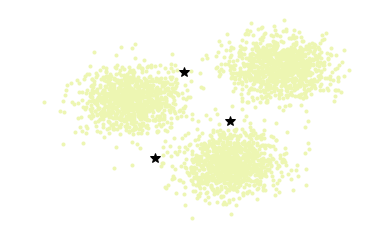

Iteration1
[[ 1.71043566  0.7827673 ]
 [ 5.29989218  2.58809718]
 [ 2.39736255  5.39513711]]


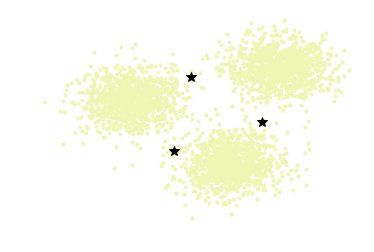

Iteration2
[[ 2.31173197  0.64983043]
 [ 5.88383741  3.54360349]
 [ 2.05860659  5.27498859]]


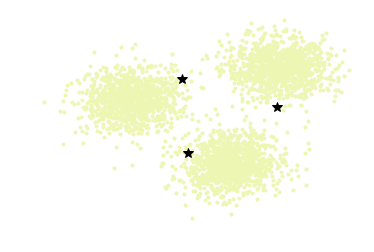

Iteration3
[[ 3.38796043  0.1875955 ]
 [ 6.15529429  5.47057241]
 [ 0.55128029  4.53849729]]


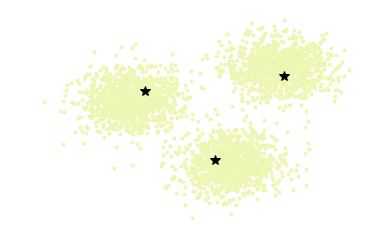

Iteration4
[[  3.97794028e+00   2.49146719e-03]
 [  6.01081785e+00   5.99634114e+00]
 [  1.43726610e-02   4.00953272e+00]]


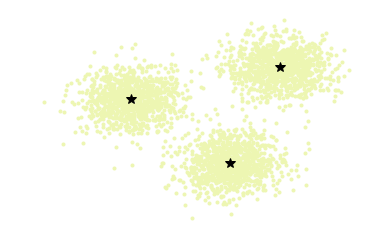

Iteration5
[[  4.00143229e+00   1.08913481e-02]
 [  6.00289521e+00   6.01186202e+00]
 [  4.70375012e-03   3.98758266e+00]]


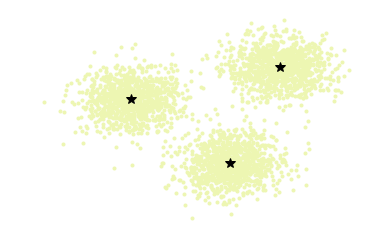

Final Results:
[[  4.00143229e+00   1.08913481e-02]
 [  6.00289521e+00   6.01186202e+00]
 [  4.70375012e-03   3.98758266e+00]]


In [123]:
iter_num = 0
for i in range(10):  
    res = D.map(nearest_centroid).reduceByKey(lambda a,b : (a[0]+b[0],a[1]+b[1])).collect() # map and reduce
    '''    
    res takes on the following format. Values will vary due to randomization
    [
      (0, (array([ 162.29207553,   58.042527  ]), 170))
      (1, (array([ 8153.4043535 ,  5436.83902566]), 2043))
      (2, (array([ 1693.32862111,  4499.47584543]), 787))
    ]
    '''
    
    res = sorted(res,key = lambda x : x[0])  # sort based on clusted ID
    
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  # divide by cluster size
    
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Final Results:"
print centroids

# MLlib Kmeans

http://spark.apache.org/docs/latest/mllib-clustering.html

In [54]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
data = spark.read.format("csv").load("./data.csv").rdd
parsedData = data.map(lambda line: array([float(line[0]),float(line[1])]))
parsedData.take(1)

[array([ 3.83773177, -0.79770583])]

In [55]:
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 3, maxIterations=20,
        runs=10, initializationMode="random")
for centroid in clusters.centers:
    print centroid

[ 4.01504763 -0.00874997]
[ 6.0326483   6.00042014]
[ 0.05490624  4.0390827 ]
